In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from imutils import resize

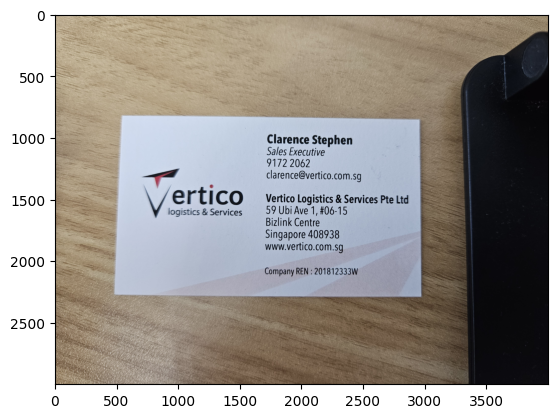

In [2]:
test_path = "./Images/20230704_151059.jpg"
img = cv2.imread(test_path)

# Convert BGR image to RGB for plt
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)

In [3]:
# resize an image for better precision
img_resize = resize(img, height=500)

In [4]:
def to_grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [5]:
img_gray = to_grayscale(img_resize)

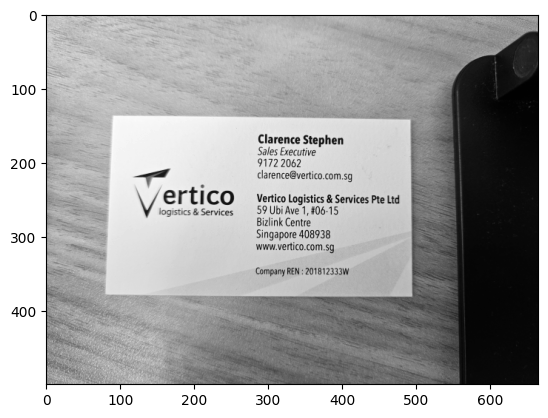

In [6]:
plt.imshow(img_gray, cmap='gray')

In [7]:
def morph(img):
    return cv2.morphologyEx(img, cv2.MORPH_GRADIENT, cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5)))

In [8]:
img_morph = morph(img_gray)

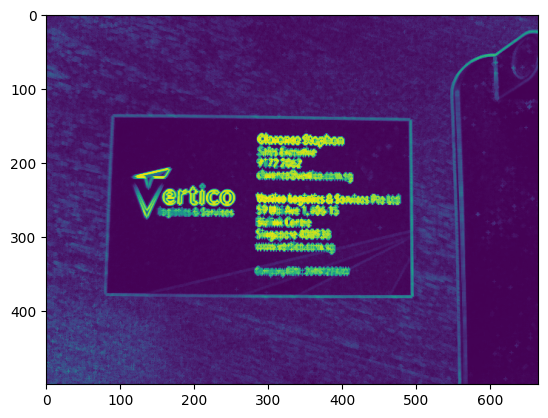

In [9]:
plt.imshow(img_morph)

In [10]:
def remove_noise(src):
    return cv2.fastNlMeansDenoising(src, None, 10, 10, 7)

In [11]:
reduced_noise = remove_noise(img_morph)

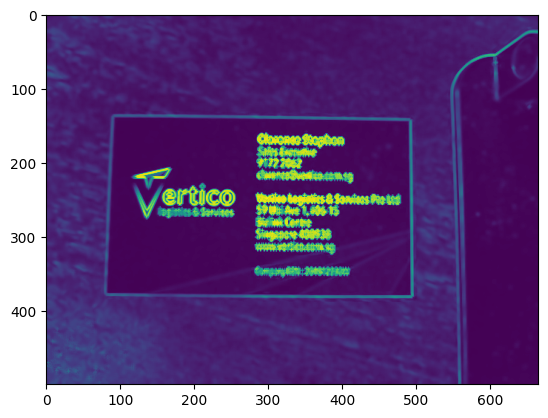

In [12]:
plt.imshow(reduced_noise)

In [13]:
def blur(img):
    return cv2.medianBlur(img, 7)

def edge(img):
    return cv2.Canny(img, 30, 30)

In [14]:
edged = edge(reduced_noise)

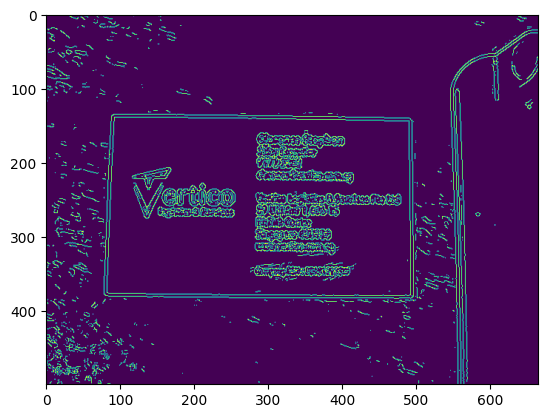

In [15]:
plt.imshow(edged)

In [16]:
from sklearn.metrics import euclidean_distances
from imutils import grab_contours

In [17]:
def get_all_boxes(edged):
	cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
	cnts = grab_contours(cnts)
	cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
 
	# loop over the contours
	for c in cnts:
		# approximate the contour
		peri = cv2.arcLength(c, True)
		approx = cv2.approxPolyDP(c, 0.02 * peri, True)
		# if our approximated contour has four points, then we
		# can assume that we have found our screen
		if len(approx) >= 4:
			screenCnt = approx
			break

	return screenCnt

def select_coords(screenCnt):
    screenCnt = screenCnt.reshape(len(screenCnt), 2)
    close_pairs = np.array(np.where(~((euclidean_distances(screenCnt, screenCnt) > 10) | (euclidean_distances(screenCnt, screenCnt) == 0)))).T

    if len(close_pairs):
        pair_cleaned = []

        for p1, p2 in close_pairs:
            a = False
            for x1, x2 in pair_cleaned:
                if p1 == x2:
                    a = not a
                    break
            if not a:
                pair_cleaned.append((p1, p2))

        remove_points = np.array(pair_cleaned)[:, 1]

        mask = np.ones(len(screenCnt), dtype=bool) 
        mask[remove_points] = False
        screenCnt = screenCnt[mask]

    #sorted_points = np.array(sorted(screenCnt, key=lambda x: x[0]))
    left, right, top, bottom = min(screenCnt[:, 0]), max(screenCnt[:, 0]), min(screenCnt[:, 1]), max(screenCnt[:, 1])

    topleft = min(screenCnt, key=lambda x: euclidean_distances([x], [(left, top)]))
    topright = min(screenCnt, key=lambda x: euclidean_distances([x], [(right, top)]))
    bottomleft = min(screenCnt, key=lambda x: euclidean_distances([x], [(left, bottom)]))
    bottomright = min(screenCnt, key=lambda x: euclidean_distances([x], [(right, bottom)]))
    
    return topleft, topright, bottomleft, bottomright


In [20]:
topleft, topright, bottomleft, bottomright = select_coords(get_all_boxes(edged))

In [23]:
def transform_image(img, topleft, topright, bottomleft, bottomright):
    max_h, max_w = img.shape[:2]

    #initialize points: input convert to top-down output
    input_pts = np.float32([list(coord) for coord in [topleft, bottomleft, bottomright, topright]])
    output_pts = np.float32([[0, 0],
                            [0, max_h - 1],
                            [max_w - 1, max_h - 1],
                            [max_w - 1, 0]])
    
    #plt.imshow(cv2.drawContours(img, [np.array([topleft, topright, bottomright, bottomleft]).reshape((4, 1, 2))], -1, (255,0,0), 2))
    #cv2.imshow("edged", edged)
    #cv2.waitKey(0)
    
    # Compute the perspective transform mat
    transform_mat = cv2.getPerspectiveTransform(input_pts, output_pts)
    out = cv2.warpPerspective(img, transform_mat, (max_w, max_h), flags=cv2.INTER_LINEAR)
    return out

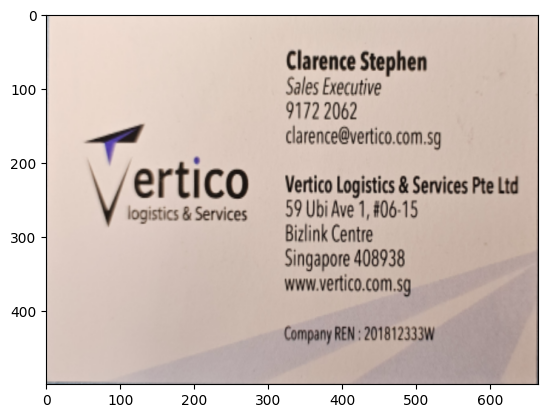

In [24]:
plt.imshow(transform_image(img_resize, topleft, topright, bottomleft, bottomright))